<h1 style='text-align:center; color:#004085; font-size:20pt; font-weight:bold; padding-bottom: 10px;'>ANALYSE DE SENTIMENTS -AVIS TRIPADVISOR</h1>

<div style="color:#004085; font-size:20pt; font-weight:bold; padding-bottom: 10px;">
INTRODUCTION
</div>

<span style="color:#495057;">
L'ère numérique a transformé le retour client en une source d'information massive et immédiatement disponible. L'<strong>Analyse de Sentiment (Sentiment Analysis)</strong> est un domaine clé du <strong>Traitement Automatique du Langage Naturel (TALN / NLP)</strong> qui vise à extraire, identifier et quantifier les opinions et émotions exprimées dans un texte. Pour le secteur du tourisme, et plus particulièrement celui des visites guidées, l'analyse des avis clients en ligne est devenue indispensable pour évaluer la qualité du service et optimiser l'offre.

Cependant, la simple note attribuée par l'utilisateur ne suffit plus. Les plateformes comme Tripadvisor sont souvent le théâtre d'avis nuancés, pouvant contenir de l'<strong>ironie</strong>, du <strong>sarcasme</strong> ou des critiques sévères masquées par un vocabulaire poli. Cette complexité linguistique crée une dissonance entre les évaluations chiffrées et le ressenti réel exprimé. L'incapacité à déchiffrer ces nuances mène à des interprétations erronées et, par conséquent, à des <strong>décisions marketing sous-optimales</strong>.

<br>

Face à la richesse mais aussi à la complexité sémantique des retours clients sur les visites guidées, la problématique centrale de ce projet est la suivante :

> **Comment concevoir et déployer une solution d'analyse de sentiments robuste et fiable, capable non seulement de déterminer la satisfaction réelle des clients en tenant compte des nuances linguistiques, mais aussi de fournir des insights actionnables pour l'optimisation des services et des décisions marketing ?**

<br>

Afin de répondre à cette problématique, ce rapport présente l'intégralité de notre démarche, de l'acquisition des données à la mise à disposition d'une interface utilisateur :

- **Acquisition des Données (Web Scraping) :** Nous décrirons d'abord la méthodologie utilisée pour collecter un jeu de données pertinent et volumineux d'avis clients de Tripadvisor.
- **Exploration et Préparation :** Une exploration approfondie sera menée pour comprendre la nature et la structure de ces données textuelles.
- **Analyse de Sentiments :** Nous comparerons l'efficacité de plusieurs approches de **NLP**, allant des méthodes **lexicales** (VADER, TextBlob) aux modèles de **Machine Learning** (Naïve Bayes) et aux modèles **Transformer** de pointe, pour identifier la solution la plus performante.
- **Déploiement et Visualisation (Streamlit) :** Enfin, nous présenterons l'application interactive développée sous **Streamlit** pour permettre une étude visuelle dynamique des résultats et faciliter la prise de décision par les utilisateurs finaux.
</span>

---

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# CHARGEMENT ET EXPLORATION DES DONNEES

In [ ]:
print("="*80)
print("ANALYSE DE SENTIMENTS - AVIS TRIPADVISOR")
print("="*80)

df = pd.read_csv('./DATA/tripadvisor_avis.csv', sep=';')

print(f"\nSTATISTIQUES DESCRIPTIVES")
print(f"{'─'*80}")
print(f"Nombre total d'avis : {len(df)}")
print(f"Période couverte : {df['date_avis'].min()} -> {df['date_avis'].max()}")
print(f"Nombre d'offres uniques : {df['titre_offre'].nunique()}")
print(f"Nombre d'auteurs uniques : {df['auteur_avis'].nunique()}")

print(f"\nDISTRIBUTION DES NOTES")
print(df['note_avis'].value_counts().sort_index())

print(f"\nTAUX DE DONNÉES MANQUANTES")
print(df.isnull().sum()[df.isnull().sum() > 0])

ANALYSE DE SENTIMENTS - AVIS TRIPADVISOR

STATISTIQUES DESCRIPTIVES
────────────────────────────────────────────────────────────────────────────────
Nombre total d'avis : 657
Période couverte : 1 août 2023 -> 9 septembre 2025
Nombre d'offres uniques : 20
Nombre d'auteurs uniques : 653

DISTRIBUTION DES NOTES
note_avis
1     33
2     18
3     31
4     87
5    488
Name: count, dtype: int64

TAUX DE DONNÉES MANQUANTES
contributions_auteur    657
type_voyage             191
dtype: int64


# PRÉTRAITEMENT AVANCE DES TEXTES

In [8]:
print(f"\n{'='*80}")
print("PRÉTRAITEMENT DES TEXTES")
print(f"{'='*80}")

import re
from collections import Counter

def nettoyer_texte(texte):
    """Nettoyage des textes"""
    if pd.isna(texte):
        return ""
    texte = str(texte).lower()
    texte = re.sub(r'http\S+|www\S+', '', texte)
    texte = re.sub(r'[^\w\s\']', ' ', texte)
    texte = re.sub(r'\s+', ' ', texte)
    return texte.strip()

def calculer_statistiques_texte(texte):
    """Calcule des métriques sur le texte"""
    if pd.isna(texte) or texte == "":
        return {'nb_mots': 0, 'nb_caracteres': 0, 'nb_phrases': 0}
    
    mots = texte.split() # Sépare par espaces
    phrases = re.split(r'[.!?]+', texte) # Sépare par .!?
    
    return {
        'nb_mots': len(mots),
        'nb_caracteres': len(texte),
        'nb_phrases': len([p for p in phrases if p.strip()])
    }

df['texte_clean'] = df['texte_avis'].apply(nettoyer_texte)

stats_texte = df['texte_clean'].apply(calculer_statistiques_texte)
df['nb_mots'] = stats_texte.apply(lambda x: x['nb_mots'])
df['nb_caracteres'] = stats_texte.apply(lambda x: x['nb_caracteres'])
df['nb_phrases'] = stats_texte.apply(lambda x: x['nb_phrases'])

print(f"Longueur moyenne des avis : {df['nb_mots'].mean():.1f} mots")
print(f"Longueur médiane : {df['nb_mots'].median():.1f} mots")
print(f"Avis le plus long : {df['nb_mots'].max()} mots")
print(f"Avis le plus court : {df['nb_mots'].min()} mots")


PRÉTRAITEMENT DES TEXTES
Longueur moyenne des avis : 51.7 mots
Longueur médiane : 37.0 mots
Avis le plus long : 355 mots
Avis le plus court : 11 mots


# ANALYSE DE SENTIMENTS - APPROCHE LEXICALE (NLTK VADER)

VADER (Valence Aware Dictionary and sEntiment Reasoner) est un algorithme spécialisé dans l'analyse de sentiments des textes courts (réseaux sociaux, avis, commentaires).


ANALYSE LEXICALE (VADER)

Distribution des sentiments VADER:
vader_sentiment
Positif    301
Neutre     269
Négatif     87
Name: count, dtype: int64

Score moyen : 0.240


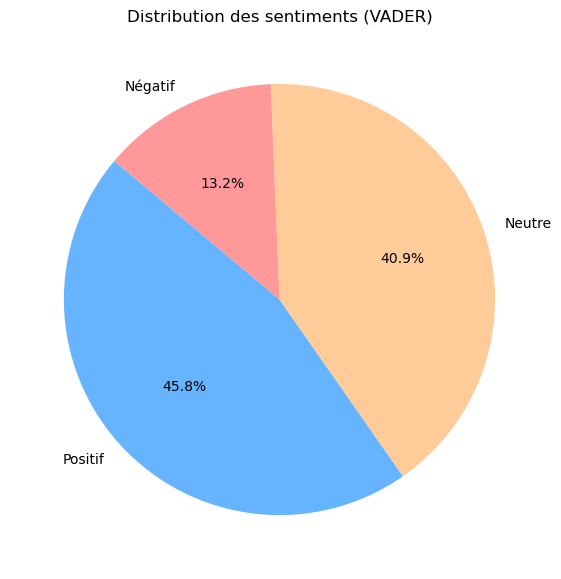

In [11]:
print(f"\n{'='*80}")
print("ANALYSE LEXICALE (VADER)")
print(f"{'='*80}")

from nltk.sentiment import SentimentIntensityAnalyzer
import nltk

try:
    nltk.data.find('vader_lexicon')
except LookupError:
    nltk.download('vader_lexicon', quiet=True)

sia = SentimentIntensityAnalyzer()

def analyser_vader(texte):
    """Analyse VADER complète"""
    if pd.isna(texte) or texte == "":
        return {'compound': 0, 'pos': 0, 'neu': 1, 'neg': 0}
    scores = sia.polarity_scores(texte)
    return scores

vader_scores = df['texte_clean'].apply(analyser_vader)
df['vader_compound'] = vader_scores.apply(lambda x: x['compound'])
df['vader_pos'] = vader_scores.apply(lambda x: x['pos'])
df['vader_neg'] = vader_scores.apply(lambda x: x['neg'])
df['vader_neu'] = vader_scores.apply(lambda x: x['neu'])

def classifier_sentiment_vader(score):
    """Classification en catégories"""
    if score >= 0.05:
        return 'Positif'
    elif score <= -0.05:
        return 'Négatif'
    else:
        return 'Neutre'

df['vader_sentiment'] = df['vader_compound'].apply(classifier_sentiment_vader)

print("\nDistribution des sentiments VADER:")
print(df['vader_sentiment'].value_counts())
print(f"\nScore moyen : {df['vader_compound'].mean():.3f}")

sentiment_counts = df['vader_sentiment'].value_counts()

# Création du camembert
plt.figure(figsize=(7,7))
plt.pie(
    sentiment_counts, 
    labels=sentiment_counts.index, 
    autopct='%1.1f%%',   # Pourcentage affiché sur chaque part
    colors=['#66b3ff','#ffcc99','#ff9999'],  # Couleurs pour chaque catégorie
    startangle=140
)
plt.title("Distribution des sentiments (VADER)")
plt.show()

POURQUOI UTILISER VADER ?
AVANTAGES :
- Comprend l'intensité : "bon" vs "très bon" vs "extrêmement bon"
- Gère les négations : "pas bon" → détecté comme négatif
- Comprend l'emphase : "!!!" augmente l'intensité
- Optimisé pour textes courts : parfait pour les avis
- Prend en compte le slang : "cool", "génial", "nul"

# ANALYSE DE SENTIMENTS - TEXTBLOB

TextBlob est une bibliothèque Python simple pour le traitement du langage naturel (NLP). Contrairement à VADER qui utilise un lexique spécialisé, TextBlob fonctionne avec des algorithmes d'apprentissage automatique pré-entraînés.

### POLARITÉ (-1 à +1)
-1.0 = Extrêmement négatif

0.0 = Neutre

+1.0 = Extrêmement positif

### SUBJECTIVITÉ (0 à 1)
0.0 = Très objectif (faits, descriptions neutres)

1.0 = Très subjectif (opinions, émotions, jugements)


MÉTHODE TEXTBLOB

Distribution des sentiments TextBlob:
textblob_sentiment
Neutre     345
Positif    283
Négatif     29
Name: count, dtype: int64
Polarité moyenne : 0.181
Subjectivité moyenne : 0.338


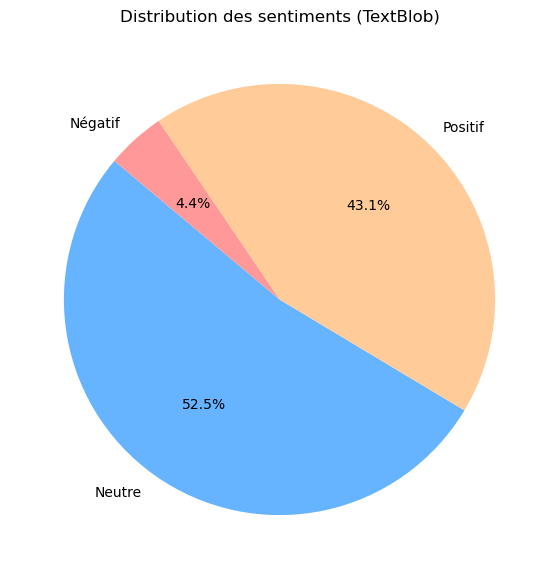

In [12]:
print(f"\n{'='*80}")
print("MÉTHODE TEXTBLOB")
print(f"{'='*80}")

from textblob import TextBlob

def analyser_textblob(texte):
    """Analyse TextBlob"""
    if pd.isna(texte) or texte == "":
        return {'polarity': 0, 'subjectivity': 0}
    try:
        blob = TextBlob(texte)
        return {
            'polarity': blob.sentiment.polarity,
            'subjectivity': blob.sentiment.subjectivity
        }
    except:
        return {'polarity': 0, 'subjectivity': 0}

textblob_scores = df['texte_clean'].apply(analyser_textblob)
df['textblob_polarity'] = textblob_scores.apply(lambda x: x['polarity'])
df['textblob_subjectivity'] = textblob_scores.apply(lambda x: x['subjectivity'])

df['textblob_sentiment'] = df['textblob_polarity'].apply(classifier_sentiment_vader)

print("\nDistribution des sentiments TextBlob:")
print(df['textblob_sentiment'].value_counts())
print(f"Polarité moyenne : {df['textblob_polarity'].mean():.3f}")
print(f"Subjectivité moyenne : {df['textblob_subjectivity'].mean():.3f}")

#représentation graphique des résultats TextBlob
sentiment_counts = df['textblob_sentiment'].value_counts()

plt.figure(figsize=(7,7))
plt.pie(
    sentiment_counts,
    labels=sentiment_counts.index,
    autopct='%1.1f%%',
    colors=['#66b3ff','#ffcc99','#ff9999'],
    startangle=140
)
plt.title("Distribution des sentiments (TextBlob)")
plt.show()

# ANALYSE DE SENTIMENTS - MODÈLE MULTINOMIAL NAÏVE BAYES

In [13]:
print(f"\n{'='*80}")
print("MÉTHODE MULTINOMIAL NAÏVE BAYES")
print(f"{'='*80}")


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import joblib
from spacy.lang.fr.stop_words import STOP_WORDS as french_stop_words

french_stop_words_list = list(french_stop_words)

def preparer_et_entrainer_naive_bayes(df):
    """Prépare et entraîne un modèle Naïve Bayes sur nos données"""
    
    print("Préparation des données pour Naïve Bayes...")
    
    # Préparer les données d'entraînement
    # Utiliser les notes comme vérité terrain (simplifié)
    df_entrainement = df.copy()
    
    # Convertir les notes en classes binaires
    # Note >= 4 -> Positif (1), Note <= 2 -> Négatif (0), Note = 3 -> Neutre (exclu pour simplification)
    df_entrainement['classe'] = df_entrainement['note_avis'].apply(
        lambda x: 1 if x >= 4 else (0 if x <= 2 else -1)  # 1=Positif, 0=Négatif, -1=Neutre
    )
    
    # Filtrer pour avoir seulement positif/négatif (exclure neutre)
    df_filtre = df_entrainement[df_entrainement['classe'] != -1]
    
    print(f"   - Avis positifs (note 4-5): {(df_filtre['classe'] == 1).sum()}")
    print(f"   - Avis négatifs (note 1-2): {(df_filtre['classe'] == 0).sum()}")
    print(f"   - Total pour l'entraînement: {len(df_filtre)} avis")
    
    if len(df_filtre) < 10:
        print("Pas assez de données pour l'entraînement")
        return None, None, None
    
    # Séparation train/test
    X_train, X_test, y_train, y_test = train_test_split(
        df_filtre['texte_clean'], 
        df_filtre['classe'], 
        test_size=0.2, 
        random_state=42,
        stratify=df_filtre['classe']
    )
    
    print(f"   - Données d'entraînement: {len(X_train)}")
    print(f"   - Données de test: {len(X_test)}")
    
    
    # Créer le pipeline TF-IDF + Naïve Bayes
    pipeline_nb = Pipeline([
        ('tfidf', TfidfVectorizer(
            max_features=1000,
            stop_words=french_stop_words_list,
            ngram_range=(1, 2),
            min_df=2
        )),
        ('nb', MultinomialNB(alpha=0.1))
    ])
    
    # Entraînement
    print("Entraînement du modèle Naïve Bayes...")
    pipeline_nb.fit(X_train, y_train)
    
    # Évaluation
    y_pred = pipeline_nb.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"Modèle entraîné avec succès!")
    print(f"Accuracy sur le test set: {accuracy:.3f}")
    
    # Rapport détaillé
    print("\nRAPPORT DE CLASSIFICATION:")
    print(classification_report(y_test, y_pred, target_names=['Négatif', 'Positif']))
    
    return pipeline_nb, X_test, y_test


def predire_naive_bayes(pipeline, texte):
    """Faire une prédiction avec le modèle Naïve Bayes"""
    if pipeline is None:
        return "Modèle non disponible", 0.5
    
    prediction = pipeline.predict([texte])[0]
    probas = pipeline.predict_proba([texte])[0]
    
    confidence = probas[prediction]  # Probabilité de la classe prédite
    
    sentiment = "POSITIF" if prediction == 1 else "NEGATIF"
    
    return sentiment, confidence, probas

# Entraîner le modèle
pipeline_naive_bayes, X_test, y_test = preparer_et_entrainer_naive_bayes(df)

df['naive_bayes_score'] = df['texte_clean'].apply(lambda x: pipeline_naive_bayes.predict_proba([x])[0][1])  # Probabilité classe positive
df['naive_bayes_normalized'] = 2 * (df['naive_bayes_score'] - 0.5)  # Conversion [0,1] -> [-1,1]



MÉTHODE MULTINOMIAL NAÏVE BAYES
Préparation des données pour Naïve Bayes...
   - Avis positifs (note 4-5): 575
   - Avis négatifs (note 1-2): 51
   - Total pour l'entraînement: 626 avis
   - Données d'entraînement: 500
   - Données de test: 126
Entraînement du modèle Naïve Bayes...
Modèle entraîné avec succès!
Accuracy sur le test set: 0.952

RAPPORT DE CLASSIFICATION:
              precision    recall  f1-score   support

     Négatif       1.00      0.40      0.57        10
     Positif       0.95      1.00      0.97       116

    accuracy                           0.95       126
   macro avg       0.98      0.70      0.77       126
weighted avg       0.95      0.95      0.94       126



In [14]:
def test_naive_bayes(texte):
    if pipeline_naive_bayes is None:
        return "Modèle non disponible"
    
    sentiment, confidence, probas = predire_naive_bayes(pipeline_naive_bayes, texte)
    
    resultat = f"""
                    NAÏVE BAYES - RÉSULTAT:
                    Texte: "{texte}"
                    Sentiment: {sentiment} 
                    Confiance: {confidence*100:.1f}%
                    Détail: Négatif({probas[0]*100:.1f}%) | Positif({probas[1]*100:.1f}%)
            """
    if confidence > 0.7:
        resultat += "Prédiction fiable"
    else:
        resultat += "Prédiction incertaine"
    
    return resultat

# print(test_naive_bayes("Super visite, guide excellent !"))
print(test_naive_bayes("Très déçu, organisation catastrophique"))
# print(test_naive_bayes("Correct sans plus"))


                    NAÏVE BAYES - RÉSULTAT:
                    Texte: "Très déçu, organisation catastrophique"
                    Sentiment: POSITIF 
                    Confiance: 68.7%
                    Détail: Négatif(31.3%) | Positif(68.7%)
            Prédiction incertaine


# ANALYSE DE SENTIMENTS - TRANSFORMERS (MÉTHODE AVANCÉE)

Transformers représente l'état de l'art en NLP utilisant l'architecture BERT (Bidirectional Encoder Representations from Transformers). Contrairement à VADER et TextBlob, c'est un modèle de deep learning pré-entraîné sur des millions de textes.

In [15]:
!pip install sacremoses

Defaulting to user installation because normal site-packages is not writeable


In [16]:
!pip install hf_xet

Defaulting to user installation because normal site-packages is not writeable


In [17]:
print(f"\n{'='*80}")
print("MÉTHODE TRANSFORMERS (CLASSIFICATEUR TOURISTIQUE)")
print(f"{'='*80}")

from transformers import pipeline
from transformers import AutoTokenizer

try:
    sentiment_model = pipeline(
        "sentiment-analysis",
        model="jgmagarino/tourist-comments-classifier",
        truncation=True,
        tokenizer=AutoTokenizer.from_pretrained(
            "jgmagarino/tourist-comments-classifier",
            truncation=True,
            padding=True,
            max_length=512
        ),
    )
    
    print("Modèle chargé avec succès. Analyse en cours...")
    
    def analyser_batch_transformers(textes, batch_size=16):
        """Analyse par lots pour optimiser les performances"""
        resultats = []
        for i in range(0, len(textes), batch_size):
            batch = textes[i:i+batch_size].tolist()
            batch = [t if t else "neutral" for t in batch]
            try:
                batch_results = sentiment_model(batch, truncation=True, max_length=512)
                resultats.extend(batch_results)
            except Exception as e:
                print(f"Erreur batch {i}: {e}")
                # Utilison 'LABEL_1' comme fallback (positif par défaut)
                resultats.extend([{'label': 'LABEL_1', 'score': 0.5}] * len(batch))
        return resultats
    
    transformer_results = analyser_batch_transformers(df['texte_clean'])
    
    df['transformer_label'] = [r['label'] for r in transformer_results]
    df['transformer_score'] = [r['score'] for r in transformer_results]
    
    def convertir_sentiment_score(label):
        """Convertit LABEL_1/LABEL_0 en score numérique"""
        if label == 'LABEL_1':
            return 1.0    # Positif
        elif label == 'LABEL_0':
            return -1.0   # Négatif
        else:
            return 0.0    # Neutre par défaut
    
    df['transformer_normalized'] = df['transformer_label'].apply(convertir_sentiment_score)
    
    # Créons une colonne avec des labels explicites pour plus de clarté
    df['transformer_sentiment'] = df['transformer_label'].map({
        'LABEL_1': 'Positif',
        'LABEL_0': 'Négatif'
    })
    
    print("\nDistribution des prédictions Transformers:")
    print(df['transformer_sentiment'].value_counts())
    print(f"Score de confiance moyen : {df['transformer_score'].mean():.3f}")
    
except Exception as e:
    print(f"Erreur lors du chargement du modèle Transformers: {e}")
    df['transformer_label'] = 'LABEL_1'
    df['transformer_score'] = 0.5
    df['transformer_normalized'] = 1.0
    df['transformer_sentiment'] = 'Positif'


MÉTHODE TRANSFORMERS (CLASSIFICATEUR TOURISTIQUE)



Device set to use cpu


Modèle chargé avec succès. Analyse en cours...

Distribution des prédictions Transformers:
transformer_sentiment
Positif    609
Négatif     48
Name: count, dtype: int64
Score de confiance moyen : 0.987


# ANALYSE COMPARATIVE DES MÉTHODES

https://huggingface.co/ProsusAI/finbert

In [18]:
print(f"\n{'='*80}")
print("COMPARAISON DES MÉTHODES")
print(f"{'='*80}")

df['note_normalized'] = (df['note_avis'] - 3) / 2

methodes = {
    'VADER': 'vader_compound',
    'TextBlob': 'textblob_polarity',
    'Naive Bayes': 'naive_bayes_normalized',
    'Transformers': 'transformer_normalized',
    'Note réelle': 'note_normalized'
}

print("\nCorrélation avec les notes réelles:")
for nom, colonne in methodes.items():
    if colonne in df.columns and colonne != 'note_normalized':
        corr = df[colonne].corr(df['note_normalized'])
        print(f"{nom:15s}: {corr:.3f}")

from sklearn.metrics import mean_absolute_error, mean_squared_error

print("\nErreurs de prédiction (par rapport aux notes):")
for nom, colonne in methodes.items():
    if colonne in df.columns and colonne != 'note_normalized':
        mae = mean_absolute_error(df['note_normalized'], df[colonne])
        rmse = np.sqrt(mean_squared_error(df['note_normalized'], df[colonne]))
        print(f"{nom:15s}: MAE={mae:.3f}, RMSE={rmse:.3f}")


COMPARAISON DES MÉTHODES

Corrélation avec les notes réelles:
VADER          : 0.283
TextBlob       : 0.224
Naive Bayes    : 0.841
Transformers   : 0.735

Erreurs de prédiction (par rapport aux notes):
VADER          : MAE=0.651, RMSE=0.751
TextBlob       : MAE=0.712, RMSE=0.783
Naive Bayes    : MAE=0.145, RMSE=0.296
Transformers   : MAE=0.162, RMSE=0.396


# EXTRACTION DE MOTS-CLÉS ET THÉMATIQUES


EXTRACTION DE MOTS-CLÉS

Top 20 mots-clés les plus importants:
 1. guide                     (score: 86.27)
 2. visite                    (score: 65.86)
 3. bien                      (score: 63.78)
 4. expérience                (score: 61.54)
 5. super                     (score: 52.75)
 6. recommande                (score: 52.29)
 7. bateau                    (score: 48.79)
 8. beaucoup                  (score: 44.44)
 9. bon                       (score: 41.88)
10. vraiment                  (score: 40.26)
11. été                       (score: 39.10)
12. bonne                     (score: 38.49)
13. moment                    (score: 36.81)
14. belle                     (score: 36.42)
15. incroyable                (score: 35.00)
16. agréable                  (score: 34.22)
17. croisière                 (score: 33.85)
18. voir                      (score: 31.82)
19. voyage                    (score: 31.81)
20. faire                     (score: 31.24)

Mots-clés dans les avis POSITIFS:
 

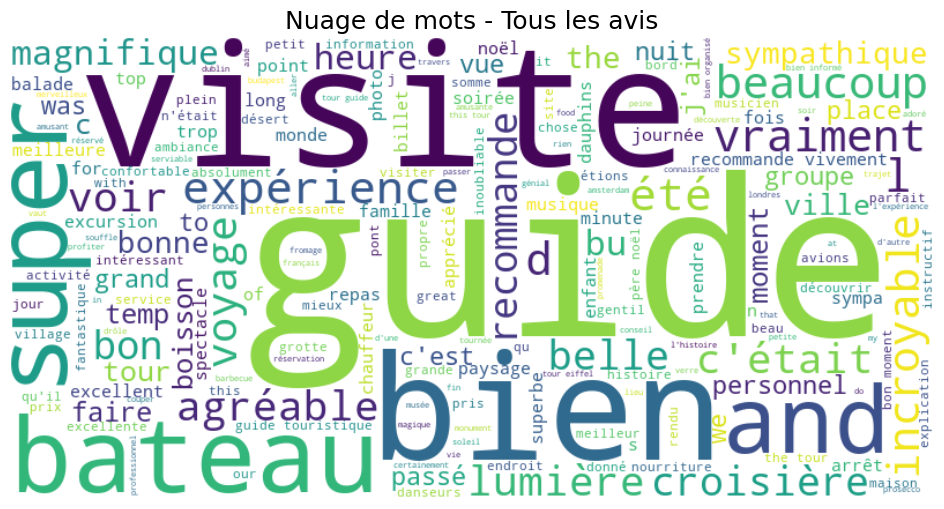

In [21]:
print(f"\n{'='*80}")
print("EXTRACTION DE MOTS-CLÉS")
print(f"{'='*80}")

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

vectorizer = TfidfVectorizer(
    max_features=30,
    stop_words=french_stop_words_list,
    ngram_range=(1, 2),
    min_df=2
)

tfidf_matrix = vectorizer.fit_transform(df['texte_clean'])
feature_names = vectorizer.get_feature_names_out()
scores = tfidf_matrix.sum(axis=0).A1
mots_cles = sorted(zip(feature_names, scores), key=lambda x: x[1], reverse=True)

print("\nTop 20 mots-clés les plus importants:")
for i, (mot, score) in enumerate(mots_cles[:20], 1):
    print(f"{i:2d}. {mot:25s} (score: {score:.2f})")

avis_positifs = df[df['note_avis'] >= 4]['texte_clean']
avis_negatifs = df[df['note_avis'] <= 2]['texte_clean']

if len(avis_positifs) > 0:
    vec_pos = TfidfVectorizer(max_features=10, stop_words=french_stop_words_list)
    tfidf_pos = vec_pos.fit_transform(avis_positifs)
    mots_pos = vec_pos.get_feature_names_out()
    scores_pos = tfidf_pos.sum(axis=0).A1
    print("\nMots-clés dans les avis POSITIFS:")
    for mot, score in sorted(zip(mots_pos, scores_pos), key=lambda x: x[1], reverse=True):
        print(f"   - {mot} ({score:.2f})")

if len(avis_negatifs) > 0:
    vec_neg = TfidfVectorizer(max_features=10, stop_words=french_stop_words_list)
    tfidf_neg = vec_neg.fit_transform(avis_negatifs)
    mots_neg = vec_neg.get_feature_names_out()
    scores_neg = tfidf_neg.sum(axis=0).A1
    print("\nMots-clés dans les avis NÉGATIFS:")
    for mot, score in sorted(zip(mots_neg, scores_neg), key=lambda x: x[1], reverse=True):
        print(f"   - {mot} ({score:.2f})")


from wordcloud import WordCloud
import matplotlib.pyplot as plt

print(f"\n{'='*80}")
print("NUAGE DE MOTS")
print(f"{'='*80}")

# Fonction pour générer et afficher un nuage de mots
def generer_nuage_de_mots(textes, titre="Nuage de mots"):
    # Combiner tous les textes en un seul
    texte_combine = " ".join(textes)
    
    # Créer le nuage
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="white",
        stopwords=french_stop_words_list,
        colormap="viridis"
    ).generate(texte_combine)
    
    # Afficher
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(titre, fontsize=18)
    plt.show()

# Nuage de tous les avis
generer_nuage_de_mots(df['texte_clean'], titre="Nuage de mots - Tous les avis")



# ANALYSE TEMPORELLE


ANALYSE TEMPORELLE

Évolution annuelle:
       note_avis  vader_compound  texte_avis
annee                                       
2017       5.000           0.932           5
2018       5.000           0.933           3
2019       4.438           0.495          16
2020       4.200           0.362           5
2021       4.154           0.580          13
2022       4.583           0.362          24
2023       4.307           0.282          75
2024       4.321           0.186         156
2025       4.603           0.207         360


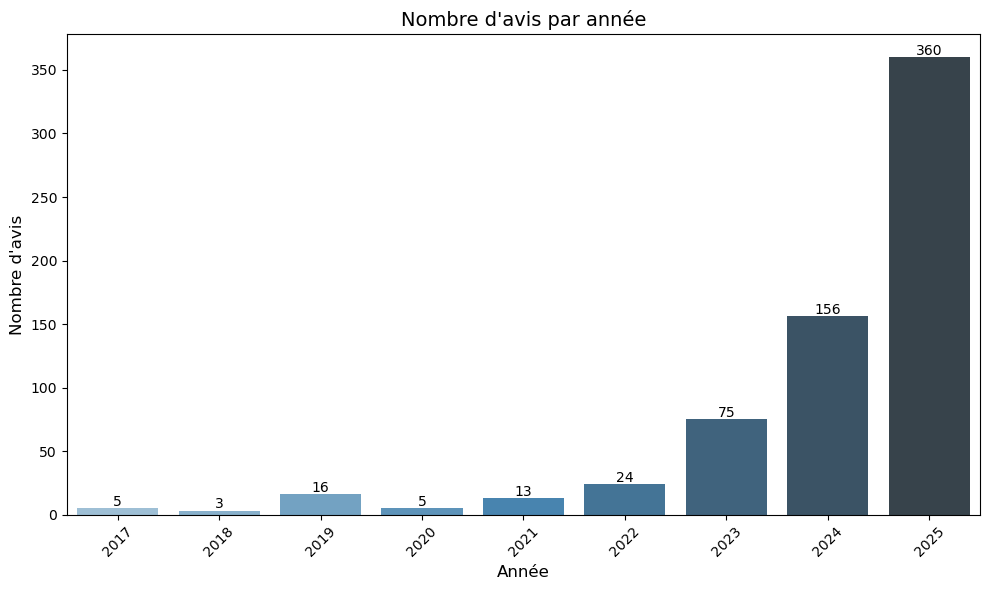

In [22]:
print(f"\n{'='*80}")
print("ANALYSE TEMPORELLE")
print(f"{'='*80}")

def parser_date(date_str):
    """Parse les dates en français"""
    if pd.isna(date_str):
        return None
    try:
        mois_fr = {
            'janvier': 1, 'février': 2, 'mars': 3, 'avril': 4,
            'mai': 5, 'juin': 6, 'juillet': 7, 'août': 8,
            'septembre': 9, 'octobre': 10, 'novembre': 11, 'décembre': 12,
            'janv': 1, 'févr': 2, 'avr': 4, 'juil': 7, 'sept': 9,
            'oct': 10, 'nov': 11, 'déc': 12
        }
        
        for mois, num in mois_fr.items():
            if mois in date_str.lower():
                parts = date_str.split()
                jour = int(parts[0])
                annee = int(parts[-1])
                return pd.Timestamp(year=annee, month=num, day=jour)
    except:
        pass
    return None

df['date_parsed'] = df['date_avis'].apply(parser_date)
df['annee'] = df['date_parsed'].dt.year
df['mois'] = df['date_parsed'].dt.month

if df['annee'].notna().sum() > 0:
    evolution_annuelle = df.groupby('annee').agg({
        'note_avis': 'mean',
        'vader_compound': 'mean',
        'texte_avis': 'count'
    }).round(3)
    
    print("\nÉvolution annuelle:")
    print(evolution_annuelle)


#visualisation

# Compter le nombre d'avis par année
avis_par_annee = df.groupby('annee')['texte_avis'].count()

# Initialiser le graphique
plt.figure(figsize=(10,6))
sns.barplot(x=avis_par_annee.index, y=avis_par_annee.values, palette="Blues_d")

# Ajouter les valeurs au-dessus des barres
for i, v in enumerate(avis_par_annee.values):
    plt.text(i, v + 2, str(v), ha='center', fontsize=10)

# Titres et labels
plt.title("Nombre d'avis par année", fontsize=14)
plt.xlabel("Année", fontsize=12)
plt.ylabel("Nombre d'avis", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# ANALYSE PAR TYPE DE VOYAGE

In [23]:
print(f"\n{'='*80}")
print("ANALYSE PAR TYPE DE VOYAGE")
print(f"{'='*80}")

if 'type_voyage' in df.columns and df['type_voyage'].notna().sum() > 0:
    analyse_voyage = df.groupby('type_voyage').agg({
        'note_avis': ['mean', 'count'],
        'vader_compound': 'mean',
        'textblob_polarity': 'mean'
    }).round(3)
    
    print("\nStatistiques par type de voyage:")
    print(analyse_voyage)


ANALYSE PAR TYPE DE VOYAGE

Statistiques par type de voyage:
                        note_avis       vader_compound textblob_polarity
                             mean count           mean              mean
type_voyage                                                             
août 2023 • En famille      4.000     2          0.409             0.167
août 2024 • En couple       3.000     2          0.147             0.338
août 2024 • En famille      5.000     2          0.459             0.342
août 2025                   5.000     4          0.275             0.333
août 2025 • En couple       5.000     3          0.305             0.317
...                           ...   ...            ...               ...
sept. 2024 • Entre amis     4.000     2          0.529             0.204
sept. 2025 • En couple      5.000    19          0.306             0.149
sept. 2025 • En famille     4.818    11          0.092             0.116
sept. 2025 • En solo        5.000     1          0.891        

# DÉTECTION D'ANOMALIES ET INSIGHTS

In [24]:
print(f"\n{'='*80}")
print("DÉTECTION D'ANOMALIES ET INSIGHTS")
print(f"{'='*80}")

df['ecart_note_sentiment'] = abs(df['note_normalized'] - df['vader_compound'])

avis_suspects = df.nlargest(5, 'ecart_note_sentiment')[
    ['titre_avis', 'note_avis', 'vader_compound', 'textblob_polarity', 'ecart_note_sentiment']
]

print("\nTop 5 avis avec le plus grand écart note/sentiment:")
print(avis_suspects.to_string())

avis_tres_positifs = df[df['vader_compound'] >= 0.8].head(3)
avis_tres_negatifs = df[df['vader_compound'] <= -0.5].head(3)

print(f"\nAvis les plus positifs: {len(df[df['vader_compound'] >= 0.8])}")
print(f"Avis les plus négatifs: {len(df[df['vader_compound'] <= -0.5])}")


DÉTECTION D'ANOMALIES ET INSIGHTS

Top 5 avis avec le plus grand écart note/sentiment:
                                                                titre_avis  note_avis  vader_compound  textblob_polarity  ecart_note_sentiment
178  Bel expérience,moment suspendu! Et organisateur sympa et bienveillant          5         -0.5267               -0.9                1.5267
361                                           entre fascination et emotion          5         -0.4588                0.0                1.4588
278                                               A faire avant de mourir😊          5         -0.4215                0.4                1.4215
215                                                        Agréable moment          5         -0.3818                0.0                1.3818
535                                   Nous avons eu une grande expérience!          5         -0.3818                0.0                1.3818

Avis les plus positifs: 79
Avis les plus négatifs: 12

# SAUVEGARDE DES RÉSULTATS

In [25]:
print(f"\n{'='*80}")
print("SAUVEGARDE DES RÉSULTATS")
print(f"{'='*80}")

colonnes_export = [
    'titre_avis', 'texte_avis', 'note_avis', 'date_avis', 'type_voyage',
    'nb_mots', 'nb_phrases',
    'vader_compound', 'vader_sentiment',
    'textblob_polarity', 'textblob_subjectivity', 'textblob_sentiment'
]

if 'transformer_label' in df.columns:
    colonnes_export.extend(['transformer_label', 'transformer_score'])

df_export = df[colonnes_export]

fichier_sortie = './analyse_sentiments_complete.csv'
df_export.to_csv(fichier_sortie, index=False, sep=';', encoding='utf-8-sig')

print(f"Résultats sauvegardés dans: {fichier_sortie}")
print(f"Nombre de colonnes exportées: {len(colonnes_export)}")



SAUVEGARDE DES RÉSULTATS
Résultats sauvegardés dans: ./analyse_sentiments_complete.csv
Nombre de colonnes exportées: 14


# RÉSUMÉ FINAL

In [26]:
print(f"\n{'='*80}")
print("RÉSUMÉ DE L'ANALYSE")
print(f"{'='*80}")

print(f"""
STATISTIQUES GÉNÉRALES
   - Nombre total d'avis analysés: {len(df)}
   - Note moyenne: {df['note_avis'].mean():.2f}/5
   - Longueur moyenne des avis: {df['nb_mots'].mean():.0f} mots
   
RÉSULTATS DES MÉTHODES
   - VADER - Sentiment moyen: {df['vader_compound'].mean():.3f}
   - TextBlob - Polarité moyenne: {df['textblob_polarity'].mean():.3f}
   - Transformers - Confiance moyenne: {df['transformer_score'].mean():.3f}
   
DISTRIBUTION DES SENTIMENTS (VADER)
   - Positifs: {(df['vader_sentiment'] == 'Positif').sum()} ({(df['vader_sentiment'] == 'Positif').sum()/len(df)*100:.1f}%)
   - Neutres: {(df['vader_sentiment'] == 'Neutre').sum()} ({(df['vader_sentiment'] == 'Neutre').sum()/len(df)*100:.1f}%)
   - Négatifs: {(df['vader_sentiment'] == 'Négatif').sum()} ({(df['vader_sentiment'] == 'Négatif').sum()/len(df)*100:.1f}%)

Analyse terminée avec succès!
""")

print("="*80)


RÉSUMÉ DE L'ANALYSE

STATISTIQUES GÉNÉRALES
   - Nombre total d'avis analysés: 657
   - Note moyenne: 4.49/5
   - Longueur moyenne des avis: 52 mots
   
RÉSULTATS DES MÉTHODES
   - VADER - Sentiment moyen: 0.240
   - TextBlob - Polarité moyenne: 0.181
   - Transformers - Confiance moyenne: 0.987
   
DISTRIBUTION DES SENTIMENTS (VADER)
   - Positifs: 301 (45.8%)
   - Neutres: 269 (40.9%)
   - Négatifs: 87 (13.2%)

Analyse terminée avec succès!



# TEST SUR UN NOUVEAU TEXT